In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="StM8QAPcQfMrcnhC2wWq")
project = rf.workspace("project29052025").project("sitting-posture-rofqf-nqxci")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
import os
import cv2
import albumentations as A
from albumentations.core.keypoints_utils import convert_keypoints_to_albumentations, convert_keypoints_from_albumentations

In [ ]:
INPUT_IMAGE_DIR = "/content/sitting-posture-3/train/images"
INPUT_LABEL_DIR = "/content/sitting-posture-3/train/labels"
OUTPUT_IMAGE_DIR = "augmented/train/images"
OUTPUT_LABEL_DIR = "augmented/train/labels"
AUG_PER_IMAGE = 5
KEYPOINT_FORMAT = 'xy'
os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.5),
    A.GaussNoise(p=0.3),
    A.Blur(p=0.2),
],
    keypoint_params=A.KeypointParams(format=KEYPOINT_FORMAT, remove_invisible=False))

In [ ]:

def parse_keypoints_with_visibility(keypoints_norm, w, h):
    """Parse keypoints dengan mempertahankan visibility flag"""
    keypoints = []
    visibility_flags = []
    i = 0

    while i < len(keypoints_norm):
        if i + 1 < len(keypoints_norm):
            x = keypoints_norm[i] * w
            y = keypoints_norm[i + 1] * h
            keypoints.append((x, y))

                      if i + 2 < len(keypoints_norm) and keypoints_norm[i + 2] in [0, 1, 2]:
                visibility_flags.append(int(keypoints_norm[i + 2]))
                i += 3  # skip x, y, visibility
            else:
                visibility_flags.append(1)
                i += 2  # skip x, y saja
        else:
            break

    return keypoints, visibility_flags

def format_keypoints_output(keypoints, visibility_flags, w, h):
    """Format keypoints kembali ke format asli dengan visibility"""
    output_parts = []
    for i, (x, y) in enumerate(keypoints):
        x_norm = x / w
        y_norm = y / h
        vis = visibility_flags[i] if i < len(visibility_flags) else 1
        output_parts.extend([f"{x_norm:.6f}", f"{y_norm:.6f}", str(vis)])

    return " ".join(output_parts)

for filename in os.listdir(INPUT_IMAGE_DIR):
    if not filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        continue

    img_path = os.path.join(INPUT_IMAGE_DIR, filename)
    label_path = os.path.join(INPUT_LABEL_DIR, filename.rsplit('.', 1)[0] + '.txt')

    image = cv2.imread(img_path)
    if image is None:
        print(f"Gagal baca gambar: {img_path}")
        continue

    h, w = image.shape[:2]

    try:
        with open(label_path, 'r') as f:
            line = f.readline().strip()
            if not line:
                print(f"Label kosong: {label_path}")
                continue

            parts = line.split()
            class_id = int(parts[0])
            keypoints_norm = list(map(float, parts[1:]))
            original_label_format = " ".join(parts[1:])
    except FileNotFoundError:
        print(f"File label tidak ditemukan: {label_path}")
        continue

    keypoints, visibility_flags = parse_keypoints_with_visibility(keypoints_norm, w, h)

    base_name = filename.rsplit('.', 1)[0]
    ori_outname = f"{base_name}_orig.jpg"
    cv2.imwrite(os.path.join(OUTPUT_IMAGE_DIR, ori_outname), image)

    with open(os.path.join(OUTPUT_LABEL_DIR, ori_outname.replace('.jpg', '.txt')), 'w') as f:
        f.write(f"{class_id} {original_label_format}\n")

    for i in range(AUG_PER_IMAGE):
        try:
            augmented = transform(image=image, keypoints=keypoints)
            aug_img = augmented['image']
            aug_kpts = augmented['keypoints']

            aug_filename = f"{base_name}_aug{i}.jpg"
            out_img_path = os.path.join(OUTPUT_IMAGE_DIR, aug_filename)
            out_lbl_path = os.path.join(OUTPUT_LABEL_DIR, aug_filename.replace(".jpg", ".txt"))

            cv2.imwrite(out_img_path, aug_img)

            h_aug, w_aug = aug_img.shape[:2]
            kpts_aug_str = format_keypoints_output(aug_kpts, visibility_flags, w_aug, h_aug)

            with open(out_lbl_path, 'w') as f:
                f.write(f"{class_id} {kpts_aug_str}\n")

        except Exception as e:
            print(f"Error saat augmentasi {filename} iterasi {i}: {str(e)}")
            continue

print("✅ Augmentasi selesai.")


✅ Augmentasi selesai.


In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8s-pose.pt')

In [ ]:
results = model.train(data="/content/sitting-posture-3/data.yaml", epochs=150, imgsz=640)

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/sitting-posture-3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=1

train: Scanning /content/augmented/train/labels... 1146 images, 0 backgrounds, 955 corrupt: 100%|██████████| 1146/1146 [00:00<00:00, 1684.80it/s]

train: /content/augmented/train/images/bad_posture_20241012_172107_png.rf.00c360d14317009b6dd52977105b5722_aug0.jpg: ignoring corrupt image/label: labels require 14 columns each
train: /content/augmented/train/images/bad_posture_20241012_172107_png.rf.00c360d14317009b6dd52977105b5722_aug1.jpg: ignoring corrupt image/label: labels require 14 columns each
train: /content/augmented/train/images/bad_posture_20241012_172107_png.rf.00c360d14317009b6dd52977105b5722_aug2.jpg: ignoring corrupt image/label: labels require 14 columns each
train: /content/augmented/train/images/bad_posture_20241012_172107_png.rf.00c360d14317009b6dd52977105b5722_aug3.jpg: ignoring corrupt image/label: labels require 14 columns each
train: /content/augmented/train/images/bad_posture_20241012_172107_png.rf.00c360d14317009b6dd52977105b5722_aug4.jpg: ignoring corrupt image/label: labels require 14 columns each
train: /content/augmented/train/images/bad_posture_20241012_172310_png.rf.5495d521c82f3373c3efa64e8873e93c_aug

train: New cache created: /content/augmented/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 16.3±9.7 MB/s, size: 29.9 KB)


val: Scanning /content/sitting-posture-3/valid/labels... 55 images, 0 backgrounds, 0 corrupt: 100%|██████████| 55/55 [00:00<00:00, 419.33it/s]

val: New cache created: /content/sitting-posture-3/valid/labels.cache


Plotting labels to runs/pose/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/pose/train2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/150      3.57G      1.373       2.21     0.7323      2.694       1.71         31        640: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         55         55      0.636      0.864      0.835      0.514      0.671      0.809      0.827      0.345



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/150       4.2G      1.113     0.6464     0.6395      1.588      1.365         40        640: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         55         55      0.819        0.5      0.546      0.353      0.819        0.5      0.546      0.368



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/150      4.23G      1.155     0.3954     0.5696      1.445       1.41         33        640: 100%|██████████| 12/12 [00:03<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         55         55      0.782      0.861      0.938      0.618      0.782      0.861      0.938      0.881



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/150      4.27G      1.096     0.3635     0.5372      1.345      1.357         42        640: 100%|██████████| 12/12 [00:03<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         55         55       0.87      0.556      0.709      0.439      0.575      0.729      0.761      0.698



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/150      4.31G      1.161     0.3251     0.4918      1.218      1.357         47        640: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         55         55      0.658      0.726      0.888      0.365      0.658      0.726       0.89      0.799



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/150      4.35G      1.193      0.327     0.4505       1.25      1.389         38        640: 100%|██████████| 12/12 [00:03<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         55         55      0.803      0.725      0.808      0.461      0.803      0.725      0.808      0.776



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/150      4.39G      1.119     0.3011     0.4289       1.15      1.358         34        640: 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         55         55      0.776      0.766      0.802      0.417      0.773      0.777      0.813      0.729



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/150      4.42G      1.153     0.2765     0.3915      1.138      1.384         35        640: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         55         55      0.738      0.787       0.75      0.441      0.738      0.787       0.75      0.731



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/150      4.46G       1.07     0.2977     0.3438      1.003      1.297         38        640: 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         55         55      0.585      0.741      0.778      0.392      0.585      0.741      0.778      0.675



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/150       4.5G      1.161     0.2891     0.3431     0.9858      1.353         40        640: 100%|██████████| 12/12 [00:03<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         55         55      0.652      0.776      0.846      0.442      0.652      0.776      0.847      0.818



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/150      4.54G      1.134     0.3031     0.2971     0.9993      1.337         43        640: 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         55         55      0.805      0.794      0.897      0.601      0.805      0.794        0.9      0.862



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/150      4.57G      1.122       0.31     0.2793      1.008      1.368         39        640: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         55         55      0.831      0.821      0.858      0.531      0.831      0.821      0.887       0.81



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/150      4.61G      1.097      0.244     0.2557     0.9383      1.346         34        640: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         55         55      0.856      0.807      0.807      0.511      0.856      0.807      0.812      0.775



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/150      4.65G      1.099     0.2572     0.2399     0.8932      1.323         40        640: 100%|██████████| 12/12 [00:03<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         55         55      0.738      0.787      0.764      0.406      0.738      0.787      0.789      0.699



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/150      4.69G      1.094     0.2186     0.2373     0.9038      1.332         38        640: 100%|██████████| 12/12 [00:03<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all         55         55      0.754      0.833      0.837      0.457      0.765      0.846      0.853      0.818



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/150      4.73G      1.077     0.2074     0.2187     0.8391       1.32         37        640: 100%|██████████| 12/12 [00:04<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         55         55      0.858      0.872      0.882      0.601      0.858      0.872      0.887      0.849



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/150      4.76G      1.047     0.2047     0.2114     0.8654      1.288         48        640: 100%|██████████| 12/12 [00:03<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         55         55      0.724      0.751      0.794      0.547      0.724      0.751      0.796      0.794



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/150       4.8G      1.025     0.1871     0.2085     0.8024      1.297         32        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         55         55      0.876      0.863      0.866      0.587      0.876      0.863      0.872      0.855



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/150      4.84G      1.066     0.2049     0.1862      0.853      1.314         37        640: 100%|██████████| 12/12 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         55         55      0.827      0.932      0.938      0.565      0.827      0.932      0.938      0.926



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/150      4.88G      1.048     0.2285     0.2065     0.8513      1.313         39        640: 100%|██████████| 12/12 [00:03<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         55         55      0.843      0.879      0.928      0.606      0.843      0.879      0.928      0.928



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/150      4.92G     0.9659     0.2503     0.1933     0.8038      1.286         31        640: 100%|██████████| 12/12 [00:03<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all         55         55        0.9      0.856      0.881      0.606        0.9      0.856      0.881      0.881



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/150      4.95G     0.9798     0.2311     0.1954     0.7818      1.275         41        640: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         55         55      0.897      0.903       0.94      0.615      0.904      0.898      0.942      0.935



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/150      4.99G     0.9465     0.1882     0.1861     0.7932      1.222         39        640: 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         55         55      0.834       0.98       0.97      0.668      0.834       0.98       0.97      0.969



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/150      5.03G     0.9882     0.1605      0.169     0.8206      1.279         35        640: 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         55         55      0.946      0.821      0.952      0.658      0.946      0.821      0.952      0.951



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/150      5.07G     0.9289     0.1988     0.1723     0.7375      1.228         40        640: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         55         55      0.905      0.848      0.932      0.594      0.905      0.848      0.932      0.932



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/150       5.1G     0.9755     0.1632     0.1792      0.726      1.255         40        640: 100%|██████████| 12/12 [00:03<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         55         55      0.962      0.903      0.982      0.695      0.962      0.903      0.982      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/150      5.14G     0.9414     0.1584     0.1492     0.7121      1.237         47        640: 100%|██████████| 12/12 [00:03<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         55         55      0.828      0.861      0.898      0.635      0.828      0.861      0.898      0.892



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/150      5.18G     0.9697      0.168     0.1693      0.722      1.237         38        640: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         55         55      0.909      0.895       0.95      0.651      0.909      0.895       0.95       0.95



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/150      5.25G     0.9913     0.1746     0.1548     0.7665      1.266         46        640: 100%|██████████| 12/12 [00:03<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         55         55      0.921      0.863      0.952       0.66      0.921      0.863      0.952      0.948



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/150      5.29G     0.9775     0.1778     0.1452     0.7787      1.252         45        640: 100%|██████████| 12/12 [00:03<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         55         55      0.929      0.932      0.978      0.689      0.929      0.932      0.978      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/150      5.36G     0.9369     0.1768     0.1557     0.7278      1.235         37        640: 100%|██████████| 12/12 [00:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         55         55       0.89      0.946      0.956      0.677       0.89      0.946      0.956      0.956



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/150      5.43G     0.8929     0.1702     0.1673     0.7026      1.208         46        640: 100%|██████████| 12/12 [00:03<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         55         55       0.83      0.959      0.951      0.593       0.83      0.959      0.951       0.95



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/150       5.5G     0.9556     0.1766     0.1444     0.6817      1.239         44        640: 100%|██████████| 12/12 [00:03<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         55         55      0.819      0.914      0.929       0.64      0.819      0.914      0.933       0.93



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/150      5.57G     0.9066      0.148     0.1616     0.6612      1.221         37        640: 100%|██████████| 12/12 [00:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         55         55      0.912      0.885      0.957      0.677      0.912      0.885      0.957      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/150      5.64G     0.8849     0.1611     0.1555     0.6793      1.215         35        640: 100%|██████████| 12/12 [00:03<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         55         55      0.929      0.892      0.971      0.653      0.929      0.892      0.971      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/150      5.71G     0.9206     0.1387     0.1303     0.6757      1.204         42        640: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         55         55      0.873      0.911      0.968      0.695      0.873      0.911      0.968      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/150      5.75G     0.9139     0.1489     0.1422      0.708      1.229         38        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         55         55      0.886      0.778      0.896      0.616      0.886      0.778      0.901      0.897



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/150      5.82G     0.9242     0.1507     0.1315     0.6856      1.251         32        640: 100%|██████████| 12/12 [00:03<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         55         55      0.869      0.848      0.905      0.642      0.869      0.848      0.905      0.905



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/150      5.89G      0.861     0.1395     0.1436     0.6471      1.205         36        640: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         55         55      0.914      0.909      0.939       0.67      0.914      0.909      0.941       0.94



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/150      5.96G     0.8596      0.124     0.1469     0.6182      1.203         36        640: 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         55         55      0.905      0.861      0.903      0.636      0.905      0.861      0.903      0.903



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/150      6.04G     0.8905     0.1313     0.1228     0.6973      1.215         36        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

                   all         55         55        0.9       0.88      0.946      0.674        0.9       0.88      0.946      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/150      6.11G     0.8663     0.1465     0.1157     0.6564      1.221         44        640: 100%|██████████| 12/12 [00:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         55         55      0.874      0.924      0.969      0.688      0.874      0.924      0.969      0.969



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/150      6.14G     0.9056     0.1423     0.1459     0.6515      1.232         38        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

                   all         55         55      0.902      0.931      0.964      0.684      0.902      0.931      0.964      0.964



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/150      6.21G     0.8726     0.1626     0.1351     0.6458      1.193         39        640: 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         55         55      0.949      0.913      0.956      0.677      0.949      0.913      0.956      0.956



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/150      6.29G     0.8908     0.1088     0.1163     0.6184      1.222         34        640: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         55         55      0.891      0.931      0.969      0.715      0.891      0.931      0.969      0.969



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/150      6.36G     0.8996     0.1245     0.1314     0.6438      1.232         45        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         55         55      0.912      0.962      0.979      0.713      0.912      0.962      0.979      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/150      6.43G     0.8505     0.1107     0.1252     0.6292      1.171         45        640: 100%|██████████| 12/12 [00:03<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         55         55      0.956      0.938      0.979      0.704      0.956      0.938      0.979      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/150       6.5G     0.8902     0.1115     0.1192     0.5987      1.184         27        640: 100%|██████████| 12/12 [00:04<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         55         55      0.884       0.95      0.967      0.671      0.884       0.95      0.967      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/150      6.54G     0.9027     0.1281     0.1147     0.6613      1.218         37        640: 100%|██████████| 12/12 [00:03<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         55         55      0.848      0.933      0.941      0.631      0.848      0.933      0.941      0.941



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/150      6.61G     0.9141     0.1307     0.1295      0.657      1.209         40        640: 100%|██████████| 12/12 [00:03<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         55         55      0.924      0.939      0.945      0.672      0.924      0.939      0.945      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/150      6.68G     0.8547     0.1277     0.1189     0.6096      1.186         38        640: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

                   all         55         55       0.91      0.833       0.84      0.572       0.91      0.833       0.84       0.84



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/150      6.75G     0.8752     0.1222     0.1395     0.6375      1.182         35        640: 100%|██████████| 12/12 [00:03<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         55         55      0.905      0.905      0.965      0.674      0.905      0.905      0.965      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/150      6.82G     0.8524     0.1265     0.1332     0.6247      1.223         42        640: 100%|██████████| 12/12 [00:03<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         55         55      0.861      0.958       0.97      0.682      0.861      0.958       0.97       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/150      6.89G     0.8269     0.1274     0.1097      0.605      1.163         42        640: 100%|██████████| 12/12 [00:04<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         55         55      0.953      0.907      0.964      0.675      0.953      0.907      0.964      0.964



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/150      6.93G     0.8863     0.1165     0.1127     0.6385      1.236         32        640: 100%|██████████| 12/12 [00:03<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         55         55      0.831      0.996      0.977      0.692      0.831      0.996      0.977      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/150         7G      0.798     0.1247     0.1304     0.6012       1.16         41        640: 100%|██████████| 12/12 [00:03<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         55         55      0.938       0.93      0.991      0.728      0.938       0.93      0.991      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/150      7.07G     0.8208     0.1266     0.1117      0.592      1.168         39        640: 100%|██████████| 12/12 [00:03<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         55         55      0.948      0.959      0.987      0.706      0.948      0.959      0.987      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/150      7.14G     0.7875      0.117     0.1257     0.5786      1.156         41        640: 100%|██████████| 12/12 [00:03<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         55         55      0.872      0.981      0.978      0.702      0.872      0.981      0.978      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/150      7.21G     0.8053     0.1298      0.106     0.5611      1.145         38        640: 100%|██████████| 12/12 [00:04<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         55         55      0.855      0.942      0.963       0.69      0.855      0.942      0.963      0.962



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/150      7.28G     0.8268     0.1247     0.1006     0.5778      1.157         45        640: 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         55         55      0.859      0.924      0.954      0.677      0.859      0.924      0.954      0.954



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/150      7.32G      0.829     0.1146     0.1207     0.5616      1.152         41        640: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         55         55      0.868      0.913      0.956      0.668      0.868      0.913      0.956      0.956



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/150      7.39G     0.8607     0.1396     0.1144      0.573      1.189         39        640: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

                   all         55         55      0.861      0.937      0.961      0.689      0.861      0.937      0.961      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/150      3.88G     0.8199     0.1267     0.1126     0.5762      1.178         44        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         55         55      0.889      0.907      0.953      0.694      0.889      0.907      0.953      0.953



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/150      3.88G     0.8123     0.1055    0.09425     0.5792      1.148         35        640: 100%|██████████| 12/12 [00:03<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         55         55       0.88      0.902      0.937      0.672       0.88      0.902      0.937      0.937



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/150      3.88G      0.804     0.1081    0.09784     0.5555      1.169         30        640: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         55         55      0.827      0.903      0.933      0.663      0.827      0.903      0.933      0.933



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/150      3.88G      0.751    0.09153     0.1112     0.5067      1.126         42        640: 100%|██████████| 12/12 [00:03<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         55         55      0.805      0.978      0.957      0.691      0.805      0.978      0.957      0.957



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/150      3.88G     0.7849     0.1122     0.1051     0.5246       1.15         43        640: 100%|██████████| 12/12 [00:03<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         55         55      0.825       0.98      0.961      0.711      0.825       0.98      0.961      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/150      3.88G     0.7963     0.1135     0.1057     0.5381      1.169         34        640: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         55         55      0.889      0.877      0.945      0.698      0.889      0.877      0.945      0.945



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/150      3.92G     0.7827    0.09884     0.1154     0.5673      1.149         40        640: 100%|██████████| 12/12 [00:03<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         55         55      0.926      0.848      0.932      0.709      0.926      0.848      0.932      0.932



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/150      3.96G     0.8309    0.09138     0.1094     0.5346      1.184         31        640: 100%|██████████| 12/12 [00:03<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         55         55      0.861      0.909      0.957      0.716      0.861      0.909      0.957      0.957



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/150      3.99G     0.8028    0.09156    0.09155     0.5323      1.148         39        640: 100%|██████████| 12/12 [00:03<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         55         55        0.8      0.973      0.949      0.708        0.8      0.973      0.949      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/150      4.07G     0.8226     0.1054    0.09476      0.555       1.18         32        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         55         55      0.851      0.882      0.939      0.707      0.851      0.882      0.939      0.939



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/150      4.14G     0.7513    0.08802     0.1092     0.5237       1.12         39        640: 100%|██████████| 12/12 [00:04<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         55         55      0.912      0.861       0.91      0.671      0.912      0.861       0.91       0.91



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/150      4.21G     0.7937    0.09405      0.096     0.5338      1.164         45        640: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         55         55      0.815      0.962      0.946      0.695      0.815      0.962      0.946      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/150      4.28G     0.7713    0.09596     0.1092     0.5048      1.157         35        640: 100%|██████████| 12/12 [00:03<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         55         55      0.858      0.915      0.915      0.663      0.858      0.915      0.915      0.915



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/150      4.32G     0.7517     0.1014    0.09886     0.5171      1.123         39        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         55         55      0.883      0.888      0.964      0.693      0.883      0.888      0.964      0.964



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/150      4.39G     0.8312    0.09253    0.08946     0.5563      1.183         34        640: 100%|██████████| 12/12 [00:03<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         55         55      0.851       0.94      0.967      0.695      0.851       0.94      0.967      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/150      4.46G     0.7858    0.09353       0.12     0.5113      1.137         39        640: 100%|██████████| 12/12 [00:03<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

                   all         55         55      0.941      0.886      0.966       0.69      0.941      0.886      0.966      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/150      4.53G     0.7197    0.09404    0.09693     0.5019      1.098         40        640: 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         55         55      0.894      0.935      0.975      0.715      0.894      0.935      0.975      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/150       4.6G     0.7424    0.09712    0.08114     0.5237      1.112         33        640: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         55         55      0.814      0.872      0.934      0.658      0.814      0.872      0.934      0.934



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/150      4.67G     0.8021    0.09379    0.08411     0.5257      1.154         51        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

                   all         55         55      0.862      0.975      0.974      0.716      0.862      0.975      0.974      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/150      4.74G     0.7276     0.1031     0.1042      0.504      1.115         42        640: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         55         55       0.83      0.911      0.953      0.706       0.83      0.911      0.953      0.953



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/150      4.81G     0.7286    0.08591    0.09559     0.4915      1.103         38        640: 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

                   all         55         55      0.906      0.944      0.959      0.701      0.906      0.944      0.959      0.959



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/150      4.85G     0.7479    0.09249      0.104     0.4977      1.141         42        640: 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         55         55      0.902      0.944      0.955      0.696      0.902      0.944      0.955      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/150      4.92G     0.7844    0.08221     0.1061     0.5115      1.165         35        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         55         55      0.863      0.965      0.961      0.699      0.863      0.965      0.961      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/150      4.99G     0.7172     0.0939    0.09128     0.5106      1.092         36        640: 100%|██████████| 12/12 [00:03<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         55         55      0.876      0.863      0.954       0.69      0.876      0.863      0.954      0.954



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/150      5.06G     0.7566    0.09464     0.1145     0.5145      1.153         35        640: 100%|██████████| 12/12 [00:03<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         55         55      0.886      0.875      0.939      0.688      0.886      0.875      0.939      0.939



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/150      5.13G      0.746    0.09361    0.09393     0.5213      1.135         39        640: 100%|██████████| 12/12 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         55         55      0.943      0.865      0.959      0.699      0.943      0.865      0.959      0.959



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/150      5.21G     0.7181    0.08557      0.104     0.4746      1.112         33        640: 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         55         55      0.899      0.956      0.958      0.701      0.899      0.956      0.958      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/150      5.24G     0.7424    0.08852    0.07644     0.4832      1.122         44        640: 100%|██████████| 12/12 [00:03<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         55         55      0.922      0.901      0.962      0.701      0.922      0.901      0.962      0.962



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/150      5.31G      0.728    0.08062     0.0925     0.4876      1.111         30        640: 100%|██████████| 12/12 [00:04<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         55         55      0.949      0.959      0.971        0.7      0.949      0.959      0.971      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/150      5.38G     0.7156    0.08371    0.08728     0.4857      1.107         35        640: 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         55         55      0.876      0.972       0.98      0.711      0.876      0.972       0.98       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/150      5.46G     0.7365    0.09337    0.08504      0.474      1.121         40        640: 100%|██████████| 12/12 [00:03<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         55         55      0.888      0.944       0.98      0.711      0.888      0.944       0.98       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/150      5.53G     0.7115    0.08587      0.097     0.4756       1.11         41        640: 100%|██████████| 12/12 [00:03<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         55         55      0.856      0.964      0.979      0.712      0.856      0.964      0.979      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/150       5.6G     0.7126    0.08159    0.08495     0.4593      1.104         31        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

                   all         55         55      0.905      0.972      0.976       0.71      0.905      0.972      0.976      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/150      5.67G     0.6742     0.1001    0.08041     0.4334        1.1         38        640: 100%|██████████| 12/12 [00:04<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         55         55       0.88      0.931      0.941      0.685       0.88      0.931      0.941      0.941



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/150      5.71G     0.6857    0.09065    0.07903     0.4316      1.089         35        640: 100%|██████████| 12/12 [00:03<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         55         55      0.874      0.927      0.919      0.666      0.874      0.927      0.919      0.919



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/150      5.78G     0.6983    0.09172    0.08395     0.4305        1.1         41        640: 100%|██████████| 12/12 [00:03<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         55         55      0.932      0.925       0.96      0.709      0.932      0.925       0.96       0.96



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/150      5.85G     0.6557    0.07982     0.1059     0.4468      1.117         35        640: 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         55         55      0.932      0.875      0.957      0.686      0.932      0.875      0.957      0.957



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/150      5.92G     0.7691    0.09761    0.07804     0.5044      1.142         38        640: 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         55         55      0.931      0.861      0.973      0.711      0.931      0.861      0.973      0.973



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/150      5.99G     0.6781     0.0872    0.08712     0.4609      1.071         41        640: 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         55         55      0.973      0.885      0.981      0.705      0.973      0.885      0.981      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/150      6.06G     0.6738     0.0871    0.09621     0.4497      1.079         37        640: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         55         55      0.932      0.919      0.961      0.711      0.932      0.919      0.961      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/150      6.13G     0.7408    0.07716    0.08496     0.4485      1.117         44        640: 100%|██████████| 12/12 [00:03<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

                   all         55         55      0.915       0.92      0.958      0.698      0.915       0.92      0.958      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/150      6.17G     0.7088    0.09043    0.08305       0.43      1.105         46        640: 100%|██████████| 12/12 [00:03<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

                   all         55         55      0.891       0.92      0.956      0.679      0.891       0.92      0.956      0.956



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/150      6.24G     0.6769    0.07023    0.07972     0.4204      1.116         43        640: 100%|██████████| 12/12 [00:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         55         55      0.921      0.933      0.955      0.694      0.921      0.933      0.955      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/150      6.31G     0.7199    0.09195    0.09978     0.4343      1.115         43        640: 100%|██████████| 12/12 [00:03<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         55         55      0.932      0.919      0.976      0.703      0.932      0.919      0.976      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/150      6.38G     0.6236    0.07183    0.08872     0.3904      1.064         35        640: 100%|██████████| 12/12 [00:03<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         55         55      0.928      0.946      0.981      0.713      0.928      0.946      0.981      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/150      6.45G     0.6773    0.08865    0.06906     0.4481       1.08         38        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         55         55      0.963      0.932      0.986       0.73      0.963      0.932      0.986      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/150      6.52G     0.7003     0.0716    0.07511     0.4325      1.115         38        640: 100%|██████████| 12/12 [00:03<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         55         55      0.898      0.973      0.981      0.728      0.898      0.973      0.981      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/150      6.56G      0.675    0.06682    0.07049      0.447      1.083         36        640: 100%|██████████| 12/12 [00:03<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         55         55      0.893      0.968      0.975      0.721      0.893      0.968      0.975      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/150      6.63G     0.6671    0.06329    0.07892      0.413        1.1         46        640: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         55         55      0.927      0.932      0.974      0.725      0.927      0.932      0.974      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/150       6.7G     0.6769    0.06536    0.06765     0.4031      1.094         40        640: 100%|██████████| 12/12 [00:03<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         55         55      0.907      0.953      0.975      0.726      0.907      0.953      0.975      0.975



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/150      6.77G      0.643    0.07191    0.07676     0.4142      1.086         37        640: 100%|██████████| 12/12 [00:03<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         55         55      0.886      0.941      0.957       0.71      0.886      0.941      0.957      0.957



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/150      6.85G      0.642    0.06913    0.08582     0.3972       1.08         34        640: 100%|██████████| 12/12 [00:03<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         55         55      0.884       0.92       0.96       0.71      0.884       0.92       0.96       0.96



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/150      6.88G      0.657    0.07959    0.07144     0.4077      1.082         40        640: 100%|██████████| 12/12 [00:03<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all         55         55      0.898      0.962       0.98      0.726      0.898      0.962       0.98       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/150      6.95G     0.6438    0.06677    0.07364     0.3909      1.088         45        640: 100%|██████████| 12/12 [00:03<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         55         55      0.908      0.935      0.967      0.714      0.908      0.935      0.967      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    117/150      7.03G     0.6856    0.07554    0.08837     0.4452      1.112         32        640: 100%|██████████| 12/12 [00:03<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         55         55      0.937       0.93      0.968      0.727      0.937       0.93      0.968      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    118/150       7.1G     0.6303    0.06703    0.07868     0.3959      1.061         35        640: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         55         55      0.929      0.986      0.987      0.743      0.929      0.986      0.987      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    119/150      7.17G     0.6446    0.07446    0.06699     0.3971      1.088         40        640: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         55         55      0.877       0.99      0.981      0.721      0.877       0.99      0.981      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    120/150      7.24G     0.6196    0.06492    0.06454      0.411      1.081         38        640: 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         55         55      0.828          1      0.968      0.708      0.828          1      0.968      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    121/150      7.28G     0.6111    0.08363    0.08647     0.3961      1.076         38        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

                   all         55         55      0.859      0.992      0.967      0.703      0.859      0.992      0.967      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    122/150      7.35G     0.6494    0.06461    0.06895     0.4032      1.077         33        640: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         55         55      0.879      0.932      0.963      0.708      0.879      0.932      0.963      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    123/150      7.42G     0.6538    0.07496    0.06796     0.3956       1.06         34        640: 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         55         55      0.883      0.918      0.949      0.691      0.883      0.918      0.949      0.949



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    124/150      3.88G     0.6701    0.07081    0.08516     0.4194      1.098         33        640: 100%|██████████| 12/12 [00:03<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         55         55      0.862      0.944      0.938      0.682      0.862      0.944      0.938      0.938



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    125/150      3.88G      0.597    0.06316     0.0685     0.3772      1.051         37        640: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         55         55      0.859      0.946      0.946      0.693      0.859      0.946      0.946      0.946



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    126/150      3.88G     0.6189    0.06587    0.06776     0.3789      1.068         37        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

                   all         55         55      0.892      0.946      0.967      0.713      0.892      0.946      0.967      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    127/150      3.88G     0.6353    0.05882    0.08142     0.3832      1.096         39        640: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         55         55      0.908      0.973      0.969      0.705      0.908      0.973      0.969      0.969



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    128/150      3.88G     0.6237    0.06642    0.08157     0.3829      1.093         35        640: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         55         55      0.882      0.945      0.968      0.711      0.882      0.945      0.968      0.968



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    129/150      3.88G     0.6269    0.05881    0.07947     0.3938      1.094         36        640: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

                   all         55         55      0.883      0.966      0.963      0.716      0.883      0.966      0.963      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    130/150      3.91G     0.5917    0.06534     0.0787      0.383      1.059         35        640: 100%|██████████| 12/12 [00:03<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         55         55      0.943      0.931       0.96      0.705      0.943      0.931       0.96       0.96



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    131/150      3.95G     0.6359    0.07093    0.06522     0.3984      1.103         30        640: 100%|██████████| 12/12 [00:04<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

                   all         55         55      0.898       0.98       0.96       0.71      0.898       0.98       0.96       0.96



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    132/150      3.99G     0.6397    0.06692    0.06961     0.3721      1.053         37        640: 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         55         55      0.921       0.98      0.963      0.703      0.921       0.98      0.963      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    133/150      4.06G     0.6234    0.06747    0.05517     0.4005      1.053         37        640: 100%|██████████| 12/12 [00:03<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         55         55      0.892      0.983      0.969      0.703      0.892      0.983      0.969      0.969



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    134/150      4.13G     0.5721    0.05761    0.07529     0.3597      1.046         41        640: 100%|██████████| 12/12 [00:03<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

                   all         55         55      0.853      0.991      0.974      0.703      0.853      0.991      0.974      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    135/150       4.2G     0.5637    0.06723    0.06458     0.3647      1.061         38        640: 100%|██████████| 12/12 [00:03<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         55         55       0.86      0.992      0.979      0.706       0.86      0.992      0.979      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    136/150      4.28G      0.572    0.06396    0.07217      0.346      1.059         33        640: 100%|██████████| 12/12 [00:04<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         55         55      0.884      0.959      0.978      0.707      0.884      0.959      0.978      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    137/150      4.35G     0.5859    0.05326    0.06924     0.3557      1.055         43        640: 100%|██████████| 12/12 [00:03<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

                   all         55         55      0.929      0.931      0.976      0.717      0.929      0.931      0.976      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    138/150      4.42G     0.5894     0.0571    0.07104     0.3615      1.043         32        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

                   all         55         55      0.941      0.931      0.974      0.717      0.941      0.931      0.974      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    139/150      4.49G     0.5652    0.06577    0.06988     0.3517      1.053         40        640: 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         55         55      0.913      0.976      0.974      0.715      0.913      0.976      0.974      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    140/150      4.53G     0.5773    0.05953    0.06782     0.3387      1.037         37        640: 100%|██████████| 12/12 [00:03<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all         55         55      0.923      0.982      0.972      0.707      0.923      0.982      0.972      0.972


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    141/150      4.86G     0.5088    0.04569    0.02253     0.2878      1.054         15        640: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         55         55      0.897      0.982      0.961      0.701      0.897      0.982      0.961      0.961



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    142/150       4.9G     0.4705    0.03714    0.03087     0.2655       1.05         15        640: 100%|██████████| 12/12 [00:04<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         55         55       0.89      0.973      0.955      0.686       0.89      0.973      0.955      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    143/150      4.94G     0.4787    0.03456    0.03294     0.2581      1.025         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         55         55      0.896      0.973      0.954      0.683      0.896      0.973      0.954      0.954



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    144/150      4.97G     0.4551    0.03432    0.02929     0.2476      1.021         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         55         55      0.883      0.979      0.958      0.691      0.883      0.979      0.958      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    145/150      5.01G     0.4613    0.03609    0.04816      0.241       1.03         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         55         55      0.881      0.986      0.963      0.698      0.881      0.986      0.963      0.963



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    146/150      5.05G     0.4697    0.03594    0.02183     0.2508      1.022         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         55         55      0.876      0.986      0.966      0.698      0.876      0.986      0.966      0.966



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    147/150      5.09G     0.4503    0.03526    0.03395     0.2395      1.022         15        640: 100%|██████████| 12/12 [00:04<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         55         55      0.874      0.986      0.967      0.706      0.874      0.986      0.967      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    148/150      5.12G     0.4536    0.03313    0.01296      0.256      1.032         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         55         55       0.87      0.986      0.969      0.703       0.87      0.986      0.969      0.969



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    149/150      5.16G     0.4446    0.03236    0.03792     0.2345     0.9974         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         55         55      0.855      0.986      0.971      0.705      0.855      0.986      0.971      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    150/150       5.2G     0.4377    0.03613    0.03904     0.2346      1.012         15        640: 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         55         55      0.926      0.903      0.971      0.704      0.926      0.903      0.971      0.971



150 epochs completed in 0.211 hours.
Optimizer stripped from runs/pose/train2/weights/last.pt, 23.1MB
Optimizer stripped from runs/pose/train2/weights/best.pt, 23.1MB

Validating runs/pose/train2/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-pose summary (fused): 81 layers, 11,413,137 parameters, 0 gradients, 29.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


                   all         55         55      0.929      0.986      0.987      0.743      0.929      0.986      0.987      0.987
                   Bad         37         37      0.918      0.973       0.99      0.785      0.918      0.973       0.99       0.99
                  Good         18         18       0.94          1      0.983        0.7       0.94          1      0.983      0.983
Speed: 0.2ms preprocess, 4.4ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/pose/train2


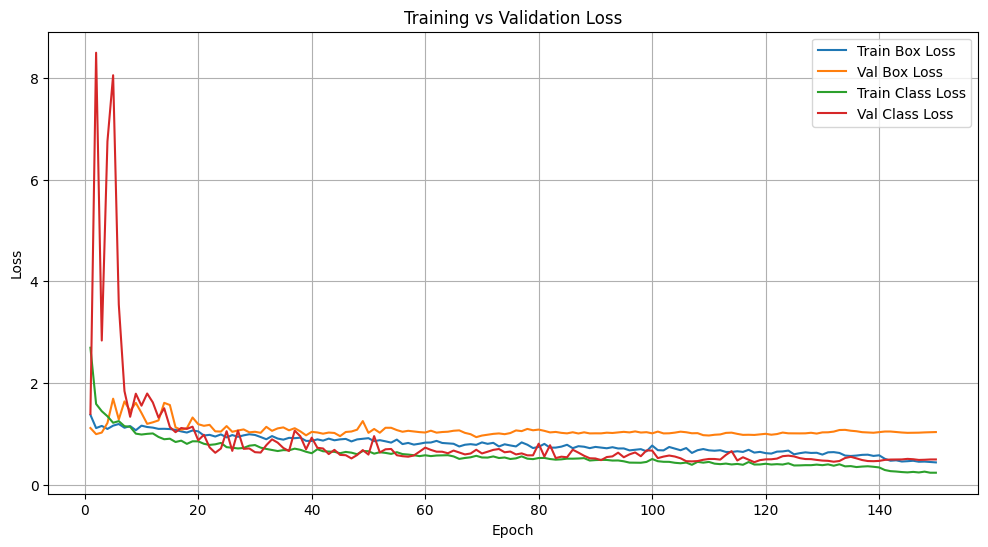

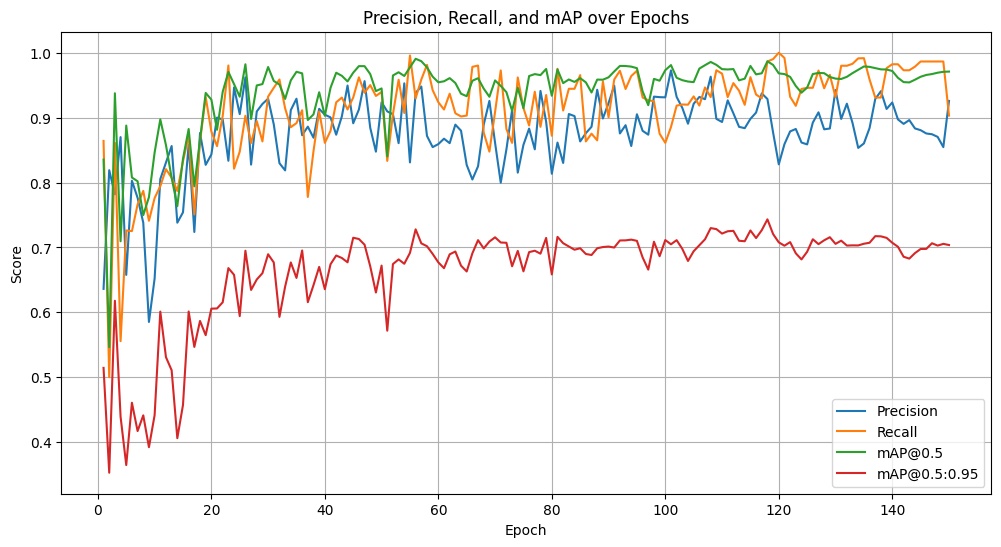

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

# Baca file CSV hasil training
results_csv = '/content/runs/pose/train2/results.csv'
df = pd.read_csv(results_csv)

# Grafik Loss
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Grafik mAP dan Precision
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Precision, Recall, and mAP over Epochs')
plt.legend()
plt.grid(True)
plt.show()
